#### Step 1: Import required libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F
import time
import copy
import os


#### Step 2: Load your dataset and split into train/val

In [2]:
data_dir = "/kaggle/input/animal-data/animal_data"  

# Define transformations (same normalization as ImageNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),     # your images are already 224x224, but just to ensure uniformity
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=transform)

# Split into 80% train, 20% val
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# For reference
class_names = full_dataset.classes
print("Classes:", class_names)
print("Total images:", len(full_dataset))
print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))


Classes: ['Bear', 'Bird', 'Cat', 'Cow', 'Deer', 'Dog', 'Dolphin', 'Elephant', 'Giraffe', 'Horse', 'Kangaroo', 'Lion', 'Panda', 'Tiger', 'Zebra']
Total images: 1944
Train size: 1555
Validation size: 389


In [3]:
# !pip install torchsummary

#### Step 3: Load pre-trained AlexNet, modify classifier for 15 classes, and move to GPU

In [4]:
# Step 3: Load pre-trained AlexNet and modify classifier
from torchsummary import summary


# Load pretrained AlexNet
alexnet_pre = models.alexnet(pretrained=True)

# Freeze all convolutional layers
for param in alexnet_pre.features.parameters():
    param.requires_grad = False

# Freeze first two FC layers (FC1 and FC2)
for param in alexnet_pre.classifier[:6].parameters():
    param.requires_grad = False

# Modify the classifier to output 15 classes
num_features = alexnet_pre.classifier[6].in_features
alexnet_pre.classifier[6] = nn.Linear(num_features, 15)  # 15 classes for animals

# Only the last layer will be trainable
for param in alexnet_pre.classifier[6].parameters():
    param.requires_grad = True

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_pre = alexnet_pre.to(device)

# Print model summary to verify changes
summary(alexnet_pre, input_size=(3, 224, 224))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 221MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

#### Step 4: Define loss function and optimizer

In [5]:
# Step 4: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # suitable for multi-class classification

# Only train parameters that require gradients (i.e., classifier)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, alexnet_pre.parameters()), lr=0.001)

#### Step 5: Training Loop with Early Stopping

In [6]:
import copy
import torch

num_epochs = 20
patience = 5  # stop if no improvement after 5 epochs

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(alexnet_pre.state_dict())

# Lists to store metrics for plotting
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            alexnet_pre.train()
            dataloader = train_loader
        else:
            alexnet_pre.eval()
            dataloader = val_loader
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = alexnet_pre(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        # Calculate average loss and accuracy
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc.item())
        else:
            val_losses.append(epoch_loss)
            val_accs.append(epoch_acc.item())
            
            # Early Stopping Check (based on validation loss)
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(alexnet_pre.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
        
        print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")
    
    # Stop training if no improvement for 'patience' epochs
    if epochs_no_improve >= patience:
        print(f"\n Early stopping triggered after {epoch+1} epochs!")
        break

# Load best model weights
alexnet_pre.load_state_dict(best_model_wts)
print(f"\n Best Validation Loss: {best_val_loss:.4f}")



Epoch 1/20
------------------------------
train Loss: 0.8913  Acc: 0.7254
val Loss: 0.3042  Acc: 0.9229

Epoch 2/20
------------------------------
train Loss: 0.2109  Acc: 0.9421
val Loss: 0.2461  Acc: 0.9383

Epoch 3/20
------------------------------
train Loss: 0.1387  Acc: 0.9736
val Loss: 0.2108  Acc: 0.9357

Epoch 4/20
------------------------------
train Loss: 0.1046  Acc: 0.9781
val Loss: 0.2104  Acc: 0.9409

Epoch 5/20
------------------------------
train Loss: 0.0909  Acc: 0.9794
val Loss: 0.2156  Acc: 0.9357

Epoch 6/20
------------------------------
train Loss: 0.0711  Acc: 0.9846
val Loss: 0.2009  Acc: 0.9486

Epoch 7/20
------------------------------
train Loss: 0.0565  Acc: 0.9865
val Loss: 0.1960  Acc: 0.9460

Epoch 8/20
------------------------------
train Loss: 0.0463  Acc: 0.9936
val Loss: 0.1863  Acc: 0.9434

Epoch 9/20
------------------------------
train Loss: 0.0441  Acc: 0.9929
val Loss: 0.1943  Acc: 0.9486

Epoch 10/20
------------------------------
train Loss:

#### Plotting learning curves

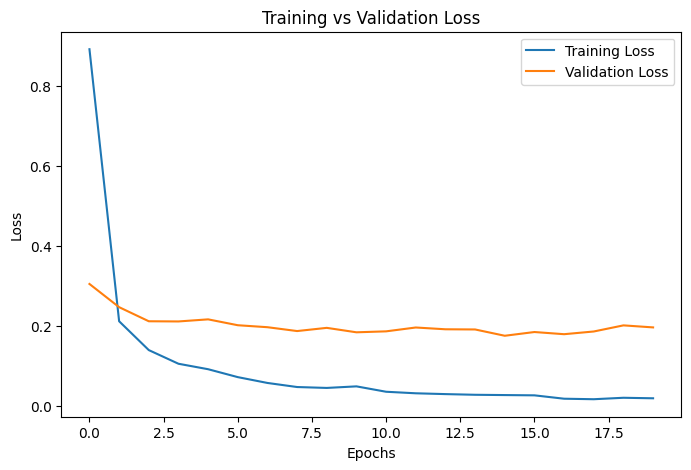

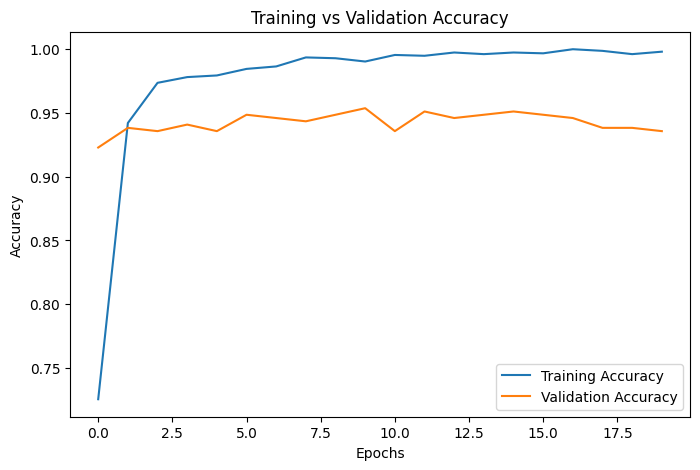

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

#### Step 6: Evaluate the trained model

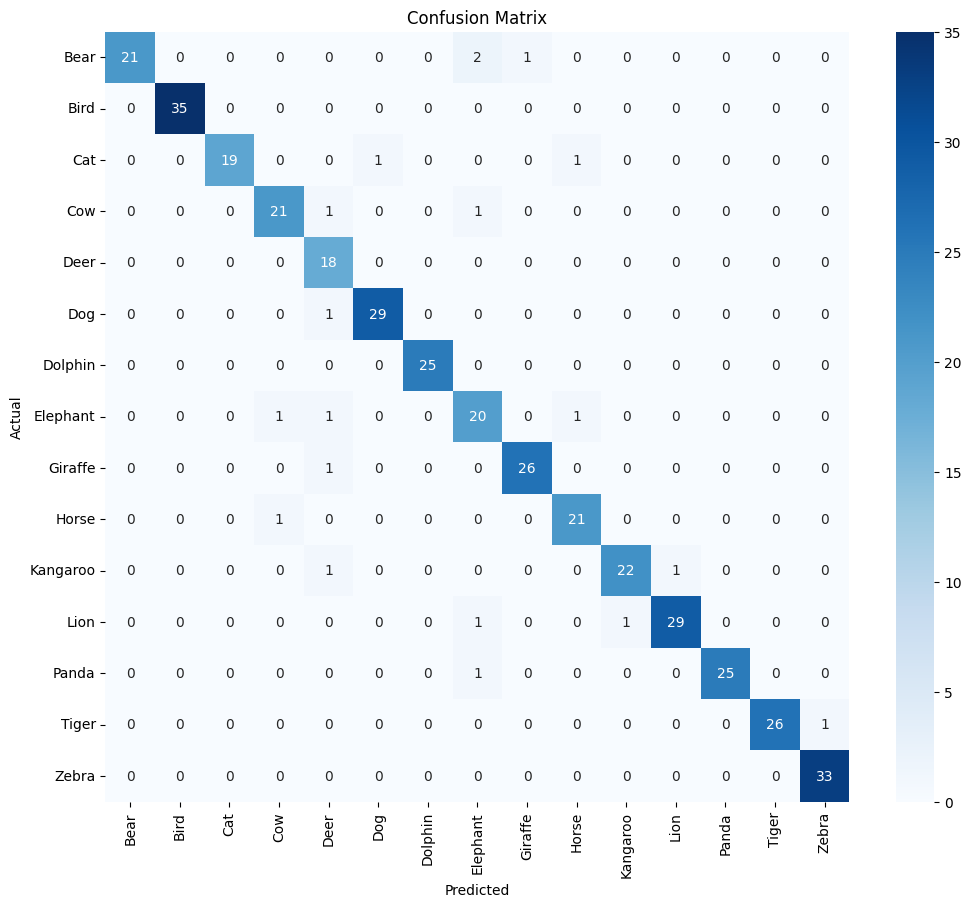

Classification Report:

              precision    recall  f1-score   support

        Bear       1.00      0.88      0.93        24
        Bird       1.00      1.00      1.00        35
         Cat       1.00      0.90      0.95        21
         Cow       0.91      0.91      0.91        23
        Deer       0.78      1.00      0.88        18
         Dog       0.97      0.97      0.97        30
     Dolphin       1.00      1.00      1.00        25
    Elephant       0.80      0.87      0.83        23
     Giraffe       0.96      0.96      0.96        27
       Horse       0.91      0.95      0.93        22
    Kangaroo       0.96      0.92      0.94        24
        Lion       0.97      0.94      0.95        31
       Panda       1.00      0.96      0.98        26
       Tiger       1.00      0.96      0.98        27
       Zebra       0.97      1.00      0.99        33

    accuracy                           0.95       389
   macro avg       0.95      0.95      0.95       389
we

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
# Set model to eval mode
alexnet_pre.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = alexnet_pre(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


#### Step 7: Test Random Images and Compare Predictions

Saved 12 random validation indices for reuse: [382, 366, 174, 190, 282, 217, 187, 145, 265, 75, 257, 224]


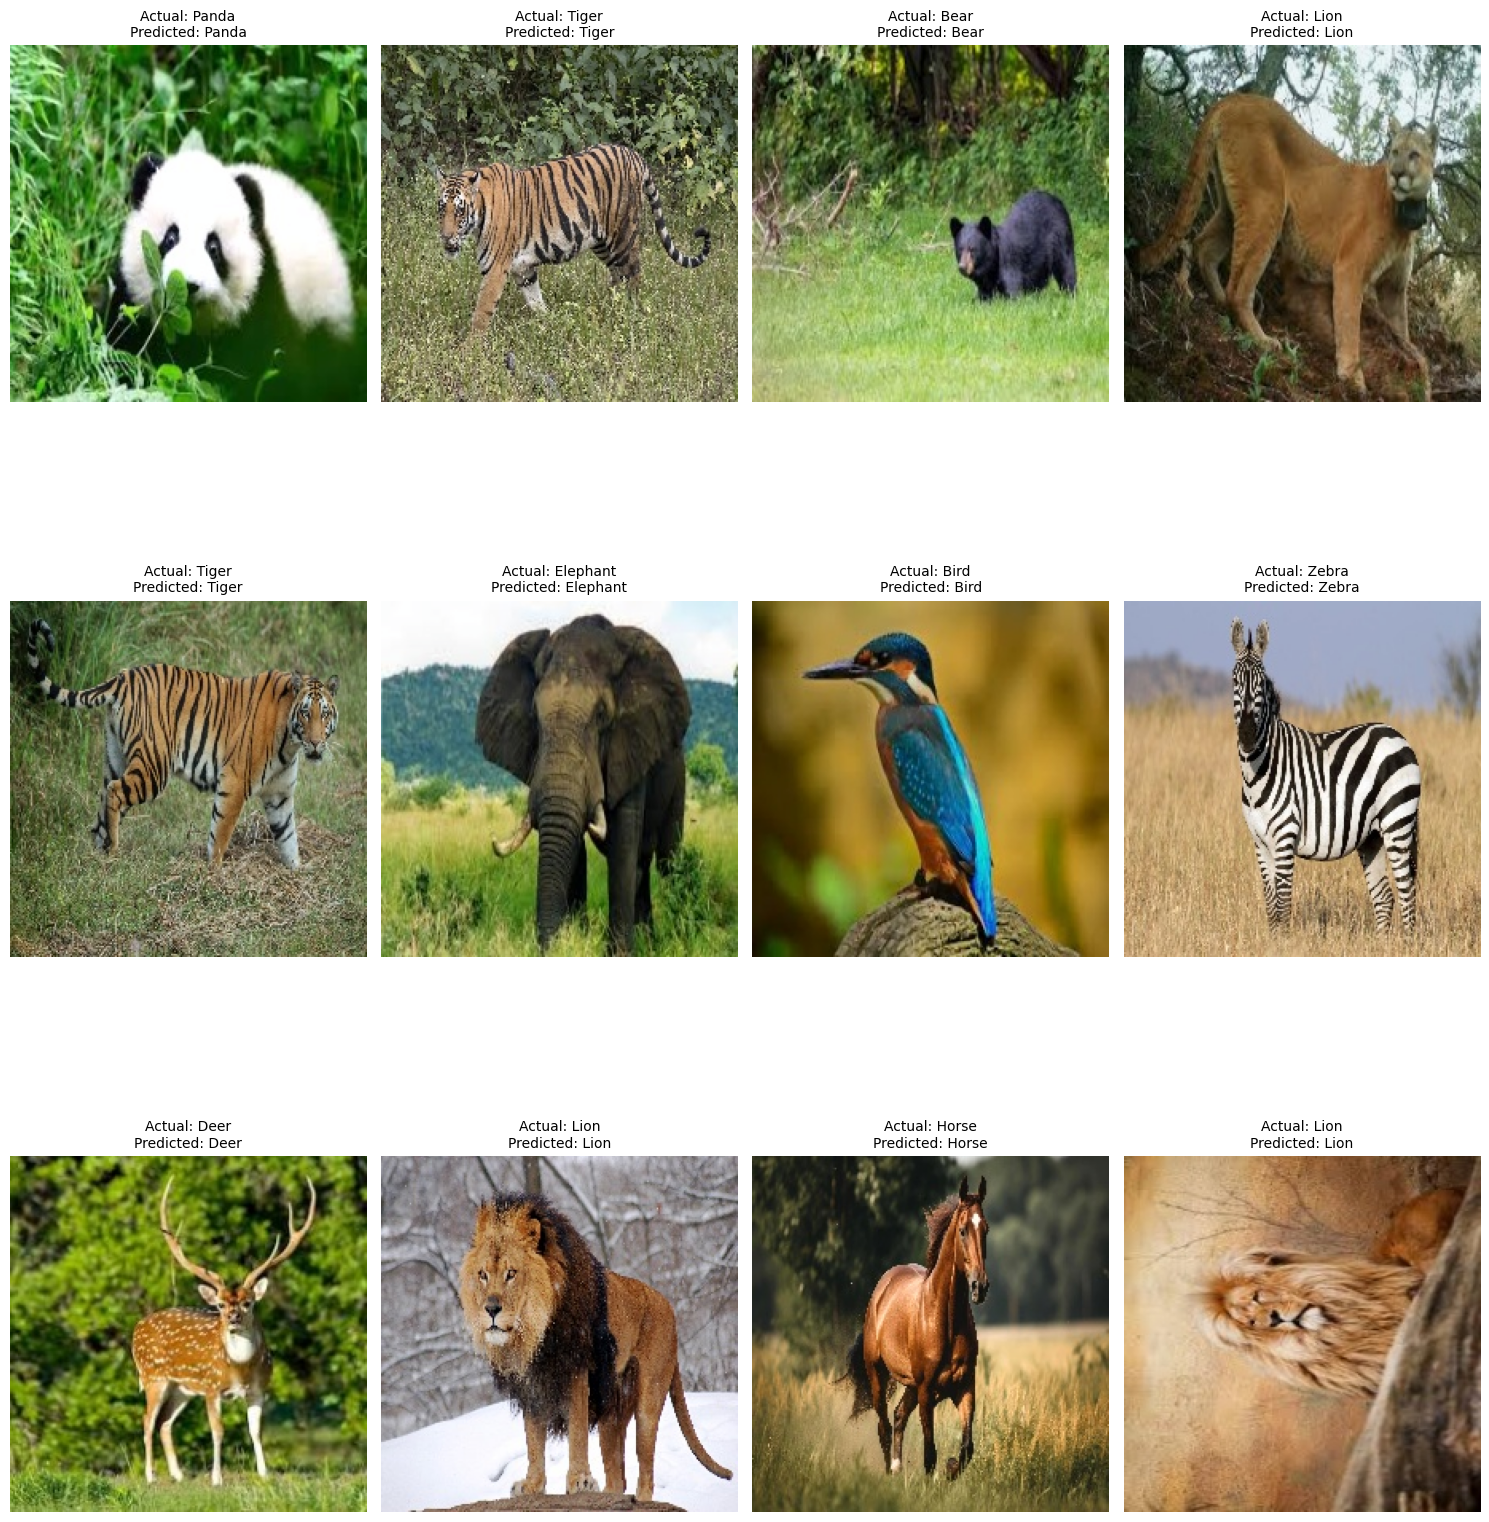

In [9]:
import random
import numpy as np

# Set model to evaluation mode
alexnet_pre.eval()

# Pick 12 random indices from the validation dataset
num_images = 12
sample_indices = random.sample(range(len(val_dataset)), num_images)

# Save these indices for later use (you can reuse them after fine-tuning)
test_sample_indices = sample_indices
print("Saved 12 random validation indices for reuse:", test_sample_indices)

# Function to show image
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')

# Display 12 images (4 rows x 3 columns)
plt.figure(figsize=(15, 18))

for i, idx in enumerate(sample_indices):
    image, label = val_dataset[idx]
    
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device)
        outputs = alexnet_pre(input_tensor)
        _, preds = torch.max(outputs, 1)
    
    actual_class = class_names[label]
    predicted_class = class_names[preds.item()]
    
    plt.subplot(3, 4, i + 1)
    imshow(image, title=f"Actual: {actual_class}\nPredicted: {predicted_class}")

plt.tight_layout()
plt.show()


## Fine-tune the Pretrained AlexNet

#### Unfreeze some layers

In [11]:
# Step: Unfreeze last two conv layers and all classifier layers 

alexnet_ft = models.alexnet(pretrained=True) 

# Freeze all layers first 
for param in alexnet_ft.parameters(): 
    param.requires_grad = False 
    
# Unfreeze last two convolutional layers (Conv4 and Conv5) 
for param in alexnet_ft.features[-5:]: # last 5 layers include Conv4, ReLU, Conv5, ReLU, MaxPool 
    if isinstance(param, nn.Conv2d): 
        param.requires_grad = True 
            
# Unfreeze all classifier layers 
for param in alexnet_ft.classifier.parameters():
    param.requires_grad = True 

# Move model to device (if not already) 
alexnet_ft = alexnet_ft.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:

#  Model Summary
print("\n---- Model Summary ----")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_ft.to(device)

# Print model summary (input size e.g. for 3x224x224 images)
summary(alexnet_ft, input_size=(3, 224, 224))



---- Model Summary ----
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPoo

#### Redefine Optimizer
Now, since more parameters are trainable, we need a lower learning rate (fine-tuning is delicate).

In [13]:
# Use a smaller learning rate for fine-tuning
optimizer = optim.Adam(filter(lambda p: p.requires_grad, alexnet_ft.parameters()), lr=1e-5)

# Loss function remains the same
criterion = nn.CrossEntropyLoss()


#### Re-train the Model

In [14]:
num_epochs = 20
patience = 3  # early stopping if val loss doesn't improve

best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(alexnet_ft.state_dict())

train_losses_ft, val_losses_ft, train_accs_ft, val_accs_ft = [], [], [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print("-" * 20)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            alexnet_ft.train()
            dataloader = train_loader
        else:
            alexnet_ft.eval()
            dataloader = val_loader
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = alexnet_ft(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        
        if phase == 'train':
            train_losses_ft.append(epoch_loss)
            train_accs_ft.append(epoch_acc.item())
        else:
            val_losses_ft.append(epoch_loss)
            val_accs_ft.append(epoch_acc.item())
        
        print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")
        
        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(alexnet_ft.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        break

# Load best fine-tuned weights
alexnet_ft.load_state_dict(best_model_wts)
print(f"\nBest fine-tuned validation loss: {best_val_loss:.4f}")


Epoch 1/20
--------------------
train Loss: 11.8318  Acc: 0.0148
val Loss: 8.5017  Acc: 0.0257
Epoch 2/20
--------------------
train Loss: 7.0986  Acc: 0.0527
val Loss: 5.5677  Acc: 0.0797
Epoch 3/20
--------------------
train Loss: 4.5988  Acc: 0.1633
val Loss: 3.5652  Acc: 0.2494
Epoch 4/20
--------------------
train Loss: 2.9240  Acc: 0.3280
val Loss: 2.3380  Acc: 0.4216
Epoch 5/20
--------------------
train Loss: 1.9954  Acc: 0.4765
val Loss: 1.6956  Acc: 0.5476
Epoch 6/20
--------------------
train Loss: 1.4696  Acc: 0.5916
val Loss: 1.3374  Acc: 0.6272
Epoch 7/20
--------------------
train Loss: 1.1408  Acc: 0.6778
val Loss: 1.1157  Acc: 0.6658
Epoch 8/20
--------------------
train Loss: 0.9418  Acc: 0.7273
val Loss: 0.9440  Acc: 0.7224
Epoch 9/20
--------------------
train Loss: 0.7980  Acc: 0.7678
val Loss: 0.8276  Acc: 0.7712
Epoch 10/20
--------------------
train Loss: 0.6823  Acc: 0.8103
val Loss: 0.7158  Acc: 0.8046
Epoch 11/20
--------------------
train Loss: 0.5715  Acc: 

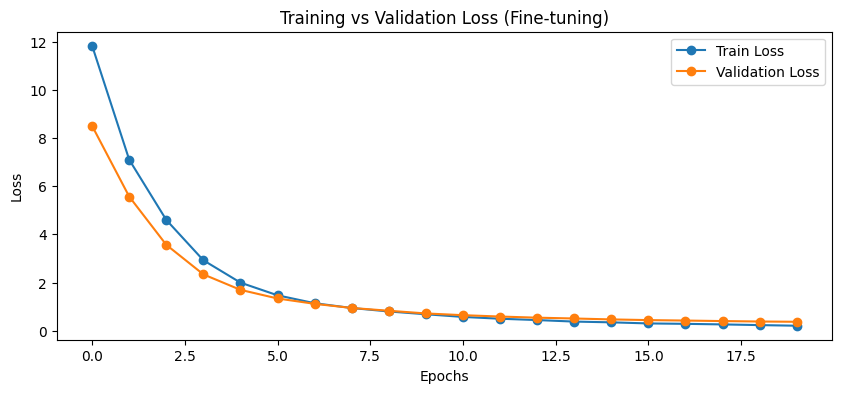

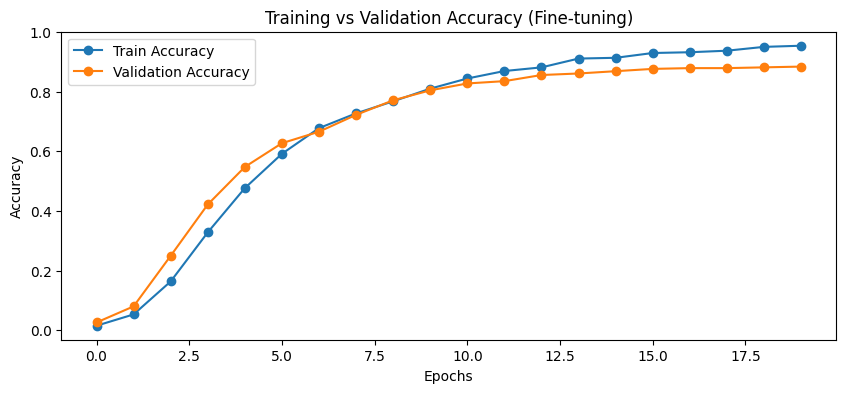

In [16]:
import matplotlib.pyplot as plt

# Plot Loss Curve for fine-tuning
plt.figure(figsize=(10,4))
plt.plot(train_losses_ft, label='Train Loss', marker='o')
plt.plot(val_losses_ft, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy Curve for fine-tuning
plt.figure(figsize=(10,4))
plt.plot(train_accs_ft, label='Train Accuracy', marker='o')
plt.plot(val_accs_ft, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy (Fine-tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


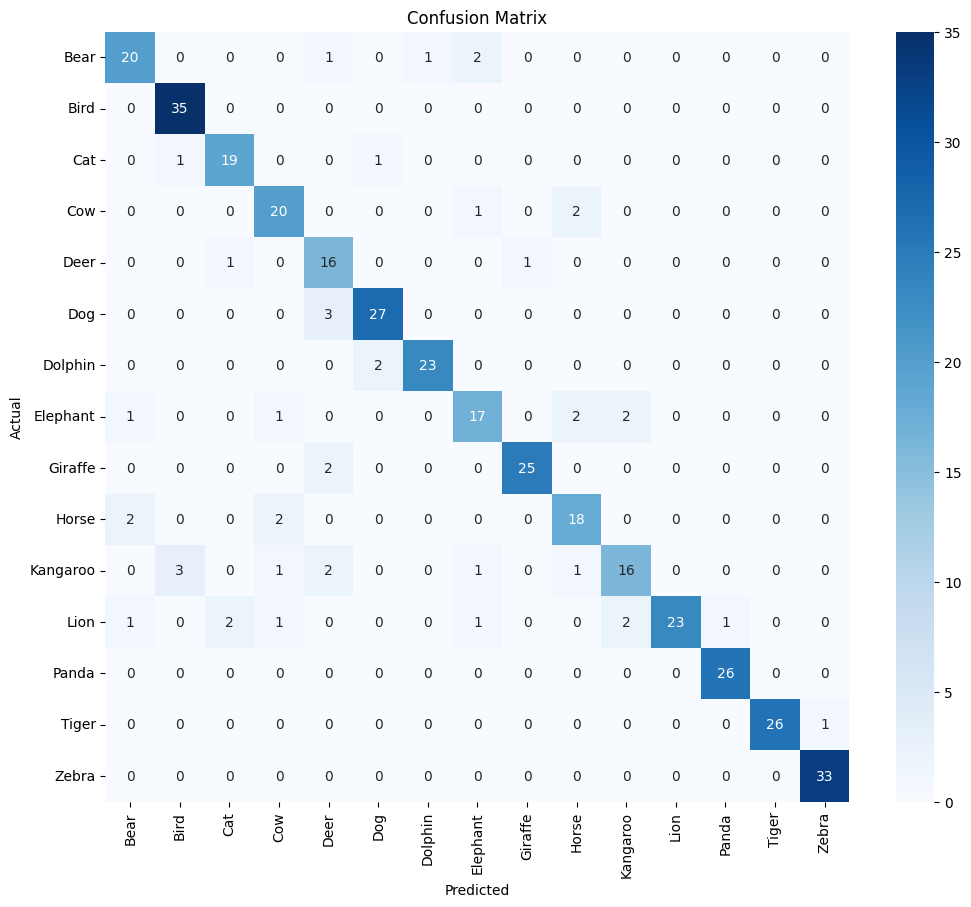

Classification Report:

              precision    recall  f1-score   support

        Bear       0.83      0.83      0.83        24
        Bird       0.90      1.00      0.95        35
         Cat       0.86      0.90      0.88        21
         Cow       0.80      0.87      0.83        23
        Deer       0.67      0.89      0.76        18
         Dog       0.90      0.90      0.90        30
     Dolphin       0.96      0.92      0.94        25
    Elephant       0.77      0.74      0.76        23
     Giraffe       0.96      0.93      0.94        27
       Horse       0.78      0.82      0.80        22
    Kangaroo       0.80      0.67      0.73        24
        Lion       1.00      0.74      0.85        31
       Panda       0.96      1.00      0.98        26
       Tiger       1.00      0.96      0.98        27
       Zebra       0.97      1.00      0.99        33

    accuracy                           0.88       389
   macro avg       0.88      0.88      0.87       389
we

In [17]:

# Set model to eval mode
alexnet_ft.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = alexnet_ft(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))


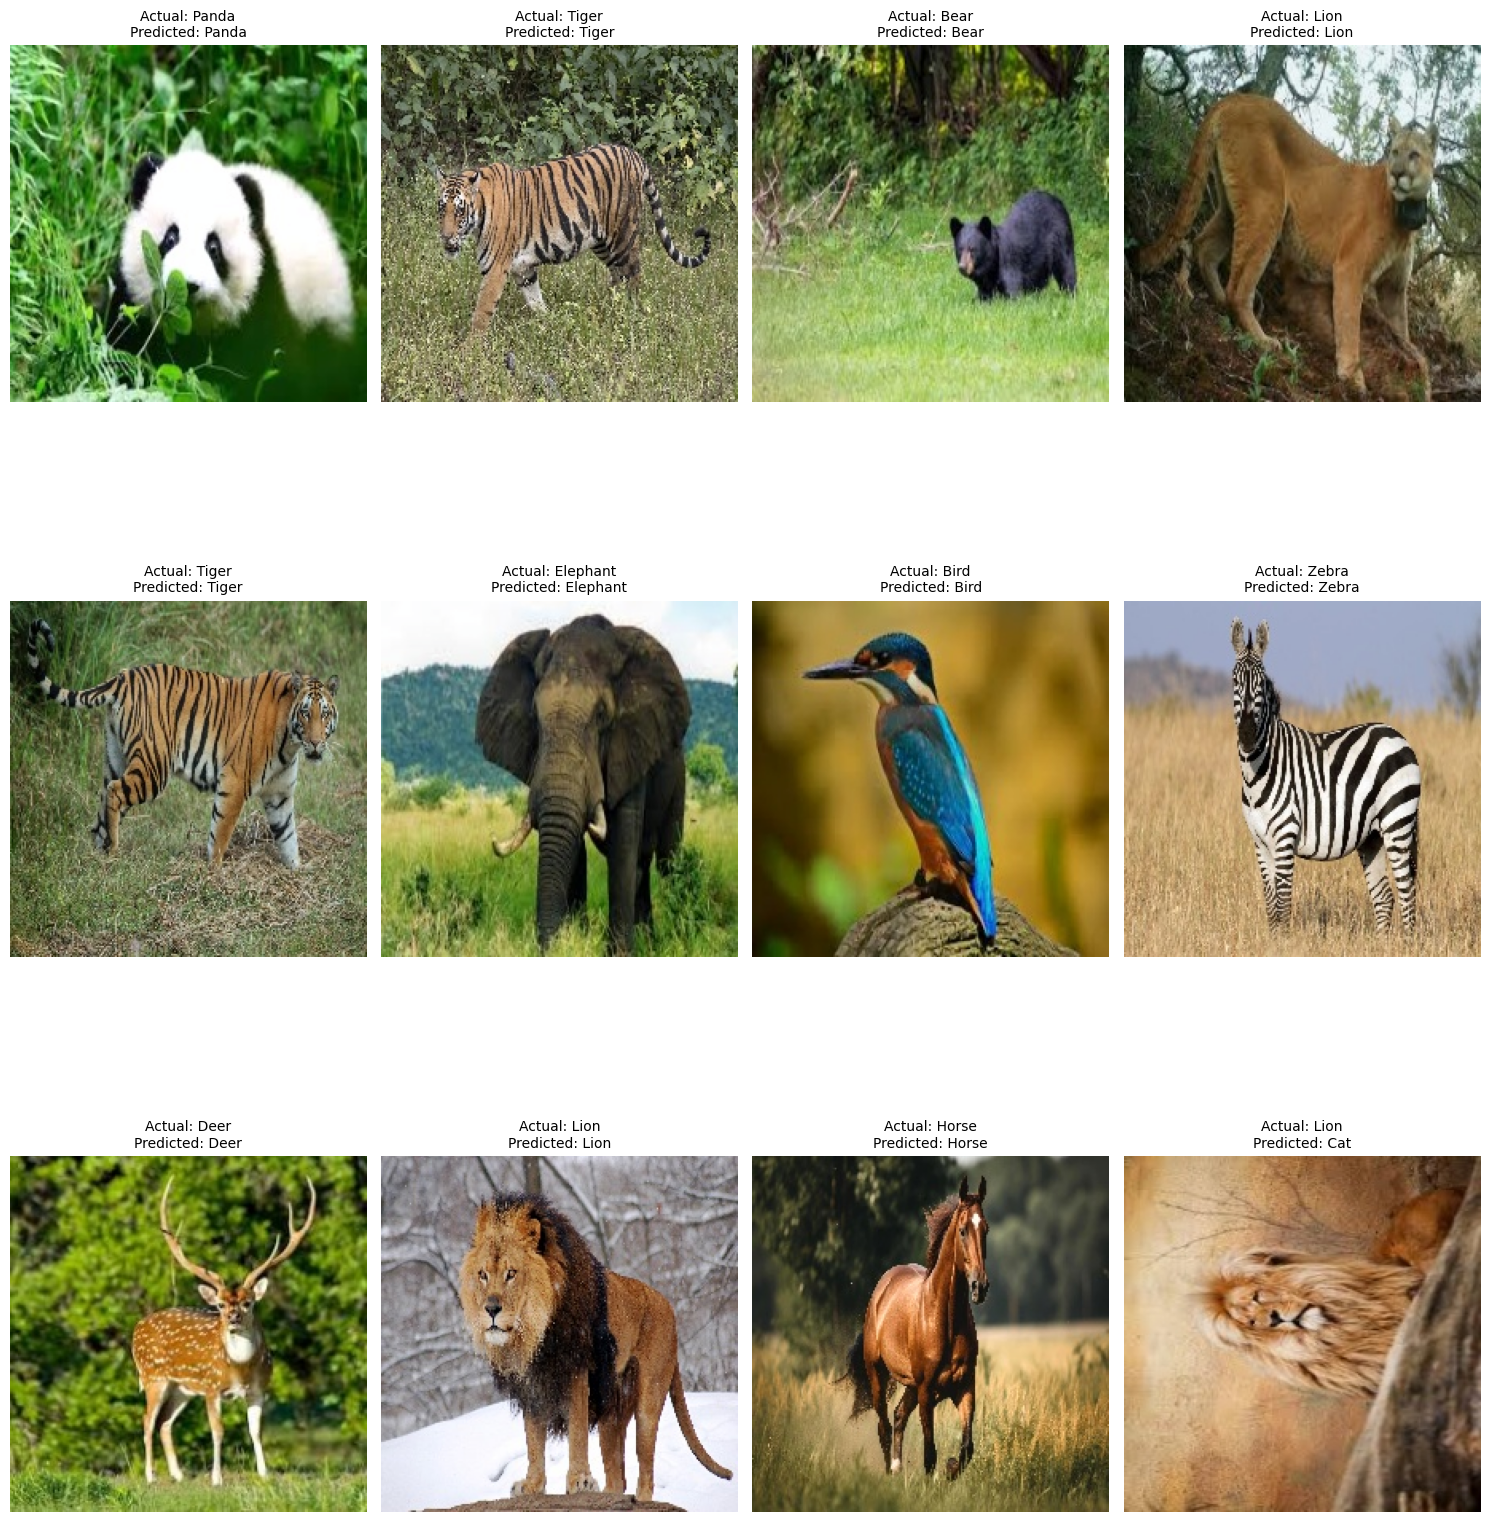

In [18]:
# Set fine-tuned model to evaluation mode
alexnet_ft.eval()

# Display the same 12 images as before (4 rows x 3 columns)
plt.figure(figsize=(15, 18))

for i, idx in enumerate(test_sample_indices):
    image, label = val_dataset[idx]
    
    with torch.no_grad():
        input_tensor = image.unsqueeze(0).to(device)
        outputs = alexnet_ft(input_tensor)
        _, preds = torch.max(outputs, 1)
    
    actual_class = class_names[label]
    predicted_class = class_names[preds.item()]
    
    plt.subplot(3, 4, i + 1)
    imshow(image, title=f"Actual: {actual_class}\nPredicted: {predicted_class}")

plt.tight_layout()
plt.show()
